In [16]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import os
import time
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import matplotlib.pyplot as plt
import hvplot.pandas

import datetime
from dateutil.relativedelta import relativedelta

import pandas_ta as ta
import technical_indicators as ti
import trade


## Initializations

In [17]:
ticker = 'NVDA'
stock_data_period = '4y'
stock_data_interval = '1d'

outfile = ('./Resources/' + str(ticker) +'_out.csv') # output data for review

short_window = 4
long_window = 20

initial_capital = 5000
share_size = 10


___
## Get live data

In [18]:
# Get live stock data
stock_df = pd.DataFrame()
stock_df = stock_df.ta.ticker(ticker, period = stock_data_period, interval = stock_data_interval)
stock_df.drop(columns=['Dividends', 'Stock Splits'],inplace=True,axis=1)
stock_df

,Open,High,Low,Close,Volume
Date,,,,,
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200
2018-10-09,65.700757,66.648056,65.170068,65.849548,27350000
2018-10-10,64.788180,65.246943,60.904757,60.927074,68494000
2018-10-11,60.054171,61.390802,58.092620,58.308369,72543600
2018-10-12,60.882444,61.881818,59.429260,61.137867,60823600
...,...,...,...,...,...
2022-10-03,123.470001,126.779999,121.050003,125.120003,54747800
2022-10-04,128.789993,132.199997,128.789993,131.669998,58418200
2022-10-05,129.110001,133.210007,126.209999,132.089996,50713100


<AxesSubplot:xlabel='Date'>

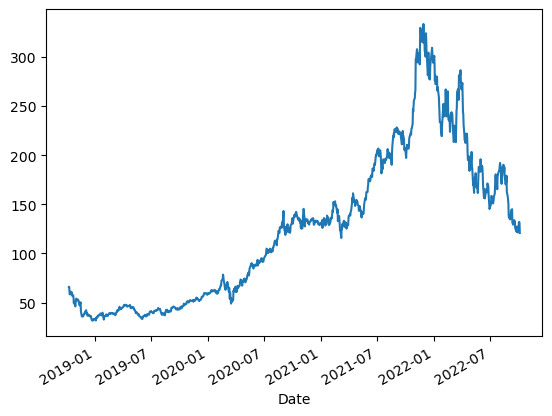

In [19]:
#Plot the True Adj Close Value
stock_df['Close'].plot()

In [20]:
df = stock_df.copy()     # reload copy of df here instead of downloading

___
## Algorithmic Trading using Simple Moving Averages Technical Indicators

#### Generate SMA columns

In [21]:
# Add SMA (Simple Moving Average) with short and long windows for algorithmic trading
df = ti.SMA(df, short_window)
df = ti.SMA(df, long_window)

df.head()


,Open,High,Low,Close,Volume,SMA_4,SMA_20
Date,,,,,,,
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200,NaN,NaN
2018-10-09,65.700757,66.648056,65.170068,65.849548,27350000,NaN,NaN
2018-10-10,64.788180,65.246943,60.904757,60.927074,68494000,NaN,NaN
2018-10-11,60.054171,61.390802,58.092620,58.308369,72543600,62.747894,NaN
2018-10-12,60.882444,61.881818,59.429260,61.137867,60823600,61.555715,NaN


#### Generate Trading Signals using the short and long SMA columns

In [22]:
# Create a column to hold the trading signal
df['Signal'] = 0.0

# Generate the trading signal 0 or 1,
# where 1 is the short-window greater than the long-window
# and 0 is when the condition is not met

SMA_short = ('SMA_' + str(short_window))
SMA_long = ('SMA_' + str(long_window))

df['Signal'][short_window:] = np.where(
    df[SMA_short][short_window:] > df[SMA_long][short_window:], 1.0, 0.0
)

# Calculate the points in time when the Signal value changes
# Identify trade entry (1) and exit (-1) points
df['Entry/Exit'] = df['Signal'].diff()

df.head()

,Open,High,Low,Close,Volume,SMA_4,SMA_20,Signal,Entry/Exit
Date,,,,,,,,,
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200,NaN,NaN,0.0,NaN
2018-10-09,65.700757,66.648056,65.170068,65.849548,27350000,NaN,NaN,0.0,0.0
2018-10-10,64.788180,65.246943,60.904757,60.927074,68494000,NaN,NaN,0.0,0.0
2018-10-11,60.054171,61.390802,58.092620,58.308369,72543600,62.747894,NaN,0.0,0.0
2018-10-12,60.882444,61.881818,59.429260,61.137867,60823600,61.555715,NaN,0.0,0.0


In [23]:
df['Entry/Exit'].value_counts()

 0.0    946
 1.0     31
-1.0     30
Name: Entry/Exit, dtype: int64

In [24]:
# Visualize entry position relative to close price
entry = df[df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = df[df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = df[[SMA_short, SMA_long]].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = moving_avgs * security_close * entry * exit

# Show the plot
entry_exit_plot.opts(
    title=(str(ticker) + ': SMA_short, SMA_long, Entry and Exit Points')
)

:Overlay
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

---
## Algorithmic Trading - Backtest trading strategy

#### Execute trades (buy, hold, sell) and calculate P&L

In [25]:
df, accumulated_shares = trade.gain_loss(df, share_size)

In [26]:
# Accumulated shares should show zero since all remaining shares have been sold at 'last' day of dataset
print("Accumulated shares =", accumulated_shares)
print (f"The initial investment made is ${initial_capital:,.2f}" )

# Calculate the total profit/loss for 100 share size orders
total_profit_loss = df["cost/proceeds"].sum()

# Print the profit/loss metrics
print(f"The total profit/loss of the trading strategy is ${total_profit_loss:,.2f}")

# # Calculate and print the return on investment (ROI)
roi = (total_profit_loss / initial_capital) * 100
print(f"The trading algorithm resulted in a return on investment (ROI) of {roi:,.2f}%")

Accumulated shares = 0
The initial investment made is $5,000.00
The total profit/loss of the trading strategy is $575.82
The trading algorithm resulted in a return on investment (ROI) of 11.52%


In [27]:
df.head()

,Open,High,Low,Close,Volume,SMA_4,SMA_20,Signal,Entry/Exit,trade_type,cost/proceeds
Date,,,,,,,,,,,
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200,NaN,NaN,0.0,NaN,hold,NaN
2018-10-09,65.700757,66.648056,65.170068,65.849548,27350000,NaN,NaN,0.0,0.0,hold,NaN
2018-10-10,64.788180,65.246943,60.904757,60.927074,68494000,NaN,NaN,0.0,0.0,hold,NaN
2018-10-11,60.054171,61.390802,58.092620,58.308369,72543600,62.747894,NaN,0.0,0.0,hold,NaN
2018-10-12,60.882444,61.881818,59.429260,61.137867,60823600,61.555715,NaN,0.0,0.0,hold,NaN


#### Calculate and plot porfolio value

In [28]:
df = trade.calc_portfolio_value(df, share_size, initial_capital)
df.to_csv('./Resources/NVDA_returns.csv')
df.head()

,Open,High,Low,Close,Volume,SMA_4,SMA_20,Signal,Entry/Exit,trade_type,cost/proceeds,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,,,,,
2018-10-08,66.087616,67.243221,64.495559,65.906586,40861200,NaN,NaN,0.0,NaN,hold,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-09,65.700757,66.648056,65.170068,65.849548,27350000,NaN,NaN,0.0,0.0,hold,NaN,0.0,0.0,0.0,5000.0,5000.0,NaN,NaN
2018-10-10,64.788180,65.246943,60.904757,60.927074,68494000,NaN,NaN,0.0,0.0,hold,NaN,0.0,0.0,0.0,5000.0,5000.0,0.0,0.0
2018-10-11,60.054171,61.390802,58.092620,58.308369,72543600,62.747894,NaN,0.0,0.0,hold,NaN,0.0,0.0,0.0,5000.0,5000.0,0.0,0.0
2018-10-12,60.882444,61.881818,59.429260,61.137867,60823600,61.555715,NaN,0.0,0.0,hold,NaN,0.0,0.0,0.0,5000.0,5000.0,0.0,0.0


In [29]:
# Visualize exit positions relative to total portfolio value
entry = df[df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize entry positions relative to total portfolio value
exit = df[df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the total portoflio value for the investment
total_portfolio_value = df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title=(ticker + ' - Total Portfolio Value'),
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

#### Show the portfolio evaluation metrics

In [31]:
# Review the portfolio evaluation DataFrame
portfolio_metrics =trade.portfolio_metrics(df, initial_capital)

print(f"The Annualized Return is {portfolio_metrics['Backtest'][0]*100:,.2f}%")
print(f"The Cummulative Return is {portfolio_metrics['Backtest'][1]*100:,.2f}%")
print(f"The Annual Volatility is {portfolio_metrics['Backtest'][2]:,.2f}")
print(f"The Sharpe Ratio is {portfolio_metrics['Backtest'][3]:,.2f}")
print(f"The Sortino Ratio is {portfolio_metrics['Backtest'][4]:,.2f}")


The Annualized Return is 4.03%
The Cummulative Return is 11.52%
The Annual Volatility is 0.09
The Sharpe Ratio is 0.34
The Sortino Ratio is 0.52
